In [22]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.svm import SVC

from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
#from xgboost import XGBClassifier

import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

import operator

In [23]:
# ссылка на датасет - https://www.kaggle.com/datasets/programmer3/cross-sport-athlete-performance-dataset?select=running_data.csv
file_path = r'C:\Users\Anast.Andreeva1\Desktop\ML\archive\running_data.csv' 
df = pd.read_csv(file_path)

In [24]:
#настройка, котопая позволяет выводить все столбцы
pd.set_option('display.max_columns', None)
df.head()

,athlete_id,age,gender,sport,vo2_max,hrv,lactate_threshold,resting_heart_rate,max_heart_rate,stride_length,cadence,force_application,power_output,endurance_score,efficiency_score,adaptability_score,skiing_potential
0,RUN_1,23.0,Female,Running,62.21,116.50,75.97,45,179,1.08,89.0,466.50,NaN,91.94,75.17,91.67,0.54
1,RUN_2,20.0,Male,Running,50.98,98.90,78.68,41,198,0.80,65.0,528.12,NaN,65.22,64.80,80.85,0.13
2,RUN_3,22.0,Female,Running,68.55,56.96,72.11,49,179,0.92,97.0,304.43,NaN,50.73,61.85,93.61,0.93
3,RUN_4,26.0,Female,Running,57.89,56.20,83.94,56,192,0.89,60.0,520.07,NaN,77.56,94.52,70.17,0.15
4,RUN_5,22.0,Male,NaN,56.31,101.21,80.60,58,176,1.47,66.0,340.50,NaN,74.46,52.44,52.87,0.03


In [25]:
# смотрю на типы данных датасета (10 - float64, 4 - int64, 3 - object)
df.dtypes.value_counts()

float64    12
object      3
int64       2
Name: count, dtype: int64

In [26]:
df.dtypes

athlete_id             object
age                   float64
gender                 object
sport                  object
vo2_max               float64
hrv                   float64
lactate_threshold     float64
resting_heart_rate      int64
max_heart_rate          int64
stride_length         float64
cadence               float64
force_application     float64
power_output          float64
endurance_score       float64
efficiency_score      float64
adaptability_score    float64
skiing_potential      float64
dtype: object

In [27]:
# проверяю количество null
pd.DataFrame(df.isnull().sum(),
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/df.shape[0]*100).astype(float).round(1)

,missing_count,missing_pct
athlete_id,0.0,0.0
age,5.0,0.4
gender,0.0,0.0
sport,17.0,1.5
vo2_max,0.0,0.0
hrv,0.0,0.0
lactate_threshold,0.0,0.0
resting_heart_rate,0.0,0.0
max_heart_rate,0.0,0.0
stride_length,0.0,0.0


In [28]:
# суммарная информация по датасету
# видим, что power_output все строки пустые. Имеет смысл этот признак исключить
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   athlete_id          1158 non-null   object 
 1   age                 1153 non-null   float64
 2   gender              1158 non-null   object 
 3   sport               1141 non-null   object 
 4   vo2_max             1158 non-null   float64
 5   hrv                 1158 non-null   float64
 6   lactate_threshold   1158 non-null   float64
 7   resting_heart_rate  1158 non-null   int64  
 8   max_heart_rate      1158 non-null   int64  
 9   stride_length       1158 non-null   float64
 10  cadence             1152 non-null   float64
 11  force_application   1158 non-null   float64
 12  power_output        0 non-null      float64
 13  endurance_score     1158 non-null   float64
 14  efficiency_score    1158 non-null   float64
 15  adaptability_score  1136 non-null   float64
 16  skiing

In [29]:
# удаляю признак power_output, т.к. в датасете он по всем строкам пустой
df = df.drop('power_output', axis=1)

# Рапределения числовых признаков

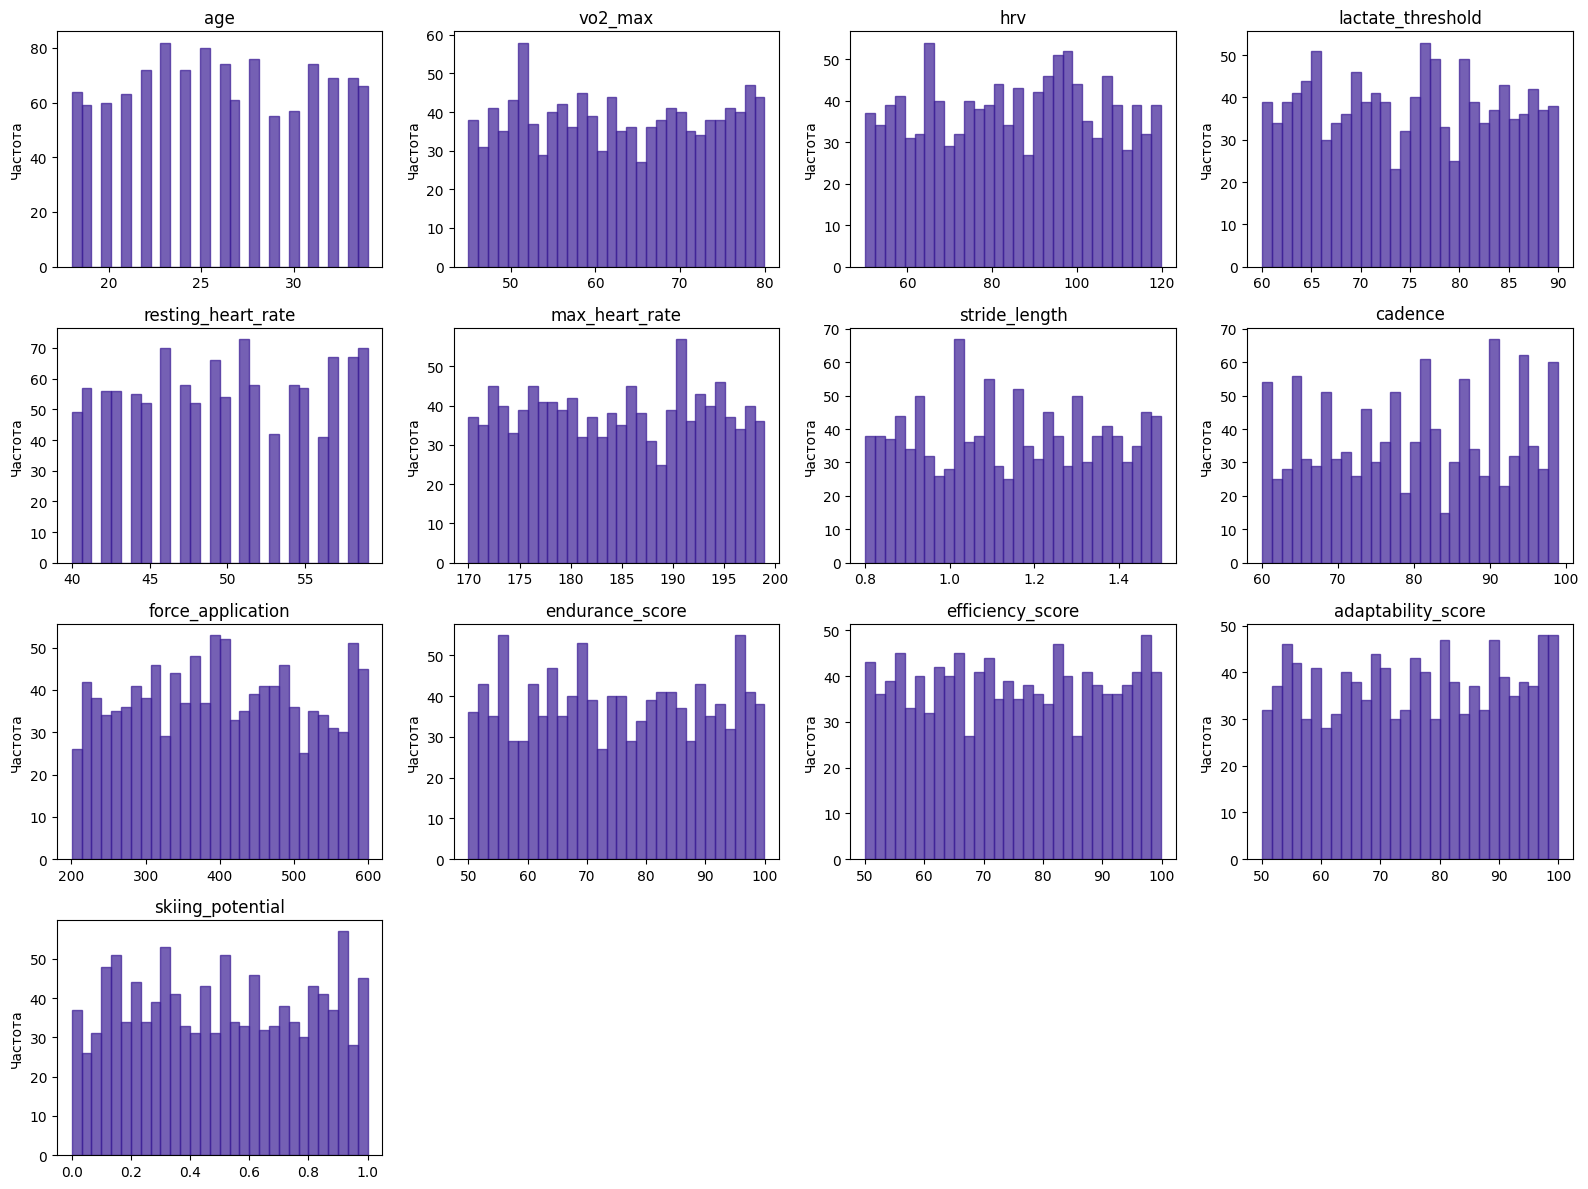

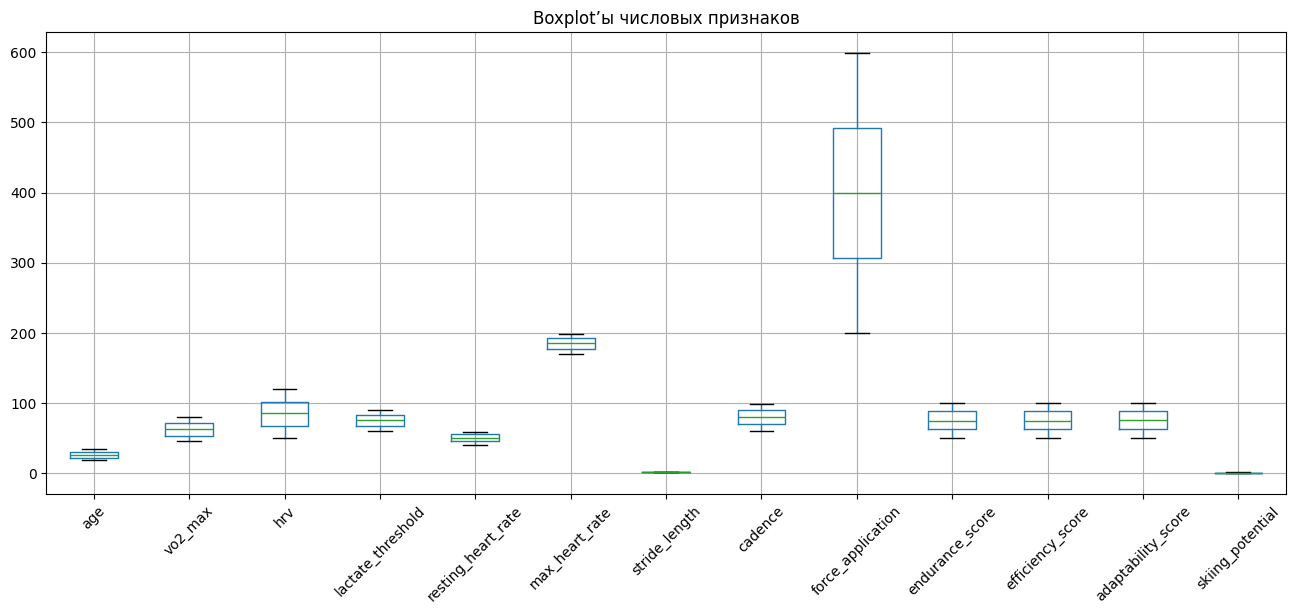

In [31]:
# Выбираю числовые признаки
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Гистограммы
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor="#3A1C95", color="#3A1C95")
    axes[i].set_title(col)
    axes[i].set_ylabel('Частота')

# Убираю пустые подграфики, если признаков меньше 16
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Boxplot’ы
plt.figure(figsize=(16, 6))
df[numeric_features].boxplot()
plt.title('Boxplot’ы числовых признаков')
plt.xticks(rotation=45)
plt.show()

In [32]:
print("Проверка нормальности (Shapiro–Wilk test):")
alpha = 0.05

for col in numeric_features:
    series = df[col].dropna()
    
    # Если данных мало, берём всё; если много — подвыборку не более 5000
    n = min(len(series), 5000)
    if n < 3:
        print(f"{col:25} : слишком мало данных для теста (n={n})")
        continue
    
    stat, p_value = stats.shapiro(series.sample(n, random_state=42))
    
    if p_value > alpha:
        print(f"{col:25} : p={p_value:.4f} — распределение можно считать нормальным")
    else:
        print(f"{col:25} : p={p_value:.4f} — распределение отклоняется от нормального")

Проверка нормальности (Shapiro–Wilk test):
age                       : p=0.0000 — распределение отклоняется от нормального
vo2_max                   : p=0.0000 — распределение отклоняется от нормального
hrv                       : p=0.0000 — распределение отклоняется от нормального
lactate_threshold         : p=0.0000 — распределение отклоняется от нормального
resting_heart_rate        : p=0.0000 — распределение отклоняется от нормального
max_heart_rate            : p=0.0000 — распределение отклоняется от нормального
stride_length             : p=0.0000 — распределение отклоняется от нормального
cadence                   : p=0.0000 — распределение отклоняется от нормального
force_application         : p=0.0000 — распределение отклоняется от нормального
endurance_score           : p=0.0000 — распределение отклоняется от нормального
efficiency_score          : p=0.0000 — распределение отклоняется от нормального
adaptability_score        : p=0.0000 — распределение отклоняется от нормально

In [33]:
def check_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\nАнализ выбросов (IQR):")
for col in numeric_features:
    n_outliers, lb, ub = check_outliers(df, col)
    print(f"{col:25} : {n_outliers:4} выбросов ({n_outliers/len(df)*100:.1f}%)")


Анализ выбросов (IQR):
age                       :    0 выбросов (0.0%)
vo2_max                   :    0 выбросов (0.0%)
hrv                       :    0 выбросов (0.0%)
lactate_threshold         :    0 выбросов (0.0%)
resting_heart_rate        :    0 выбросов (0.0%)
max_heart_rate            :    0 выбросов (0.0%)
stride_length             :    0 выбросов (0.0%)
cadence                   :    0 выбросов (0.0%)
force_application         :    0 выбросов (0.0%)
endurance_score           :    0 выбросов (0.0%)
efficiency_score          :    0 выбросов (0.0%)
adaptability_score        :    0 выбросов (0.0%)
skiing_potential          :    0 выбросов (0.0%)


C:\Users\Anast.Andreeva1\AppData\Local\Temp\ipykernel_41036\2927877639.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=nan_train_X['feature'], y=nan_train_X['nan_percent'], palette=colors)


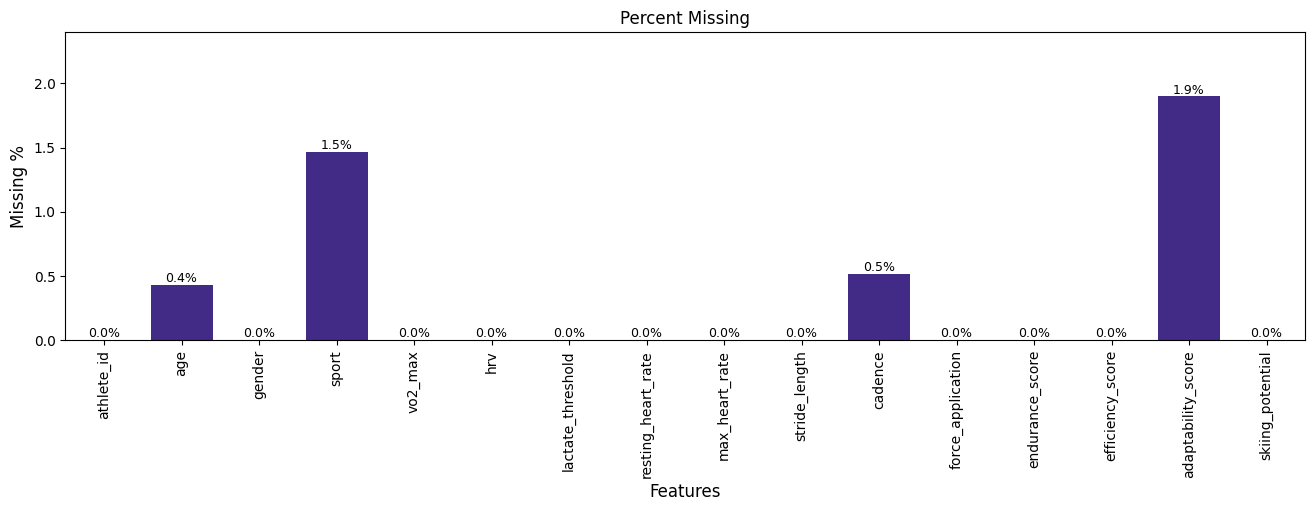

In [34]:
# Визуализируем долю пропусков для колонок
nan_train_X = ((df.isna().sum() / df.shape[0]*100)).reset_index()
nan_train_X.columns=['feature', 'nan_percent']

colors = ["#3A1C95" if val != "success_index" else "#59BBF8" for val in nan_train_X['feature']]

plt.figure(figsize=(16,4))
ax = sns.barplot(x=nan_train_X['feature'], y=nan_train_X['nan_percent'], palette=colors)
plt.title('Percent Missing')
plt.ylabel('Missing %', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)

# Добавляем проценты над каждым столбцом
for i, bar in enumerate(ax.patches):
    value = nan_train_X['nan_percent'].iloc[i]
    if not pd.isna(value):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{value:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )
# Устанавливаем максимальное значение оси Y, чтобы "в потолок не упиралось" максимальный по проценту столбец
max_value = nan_train_X['nan_percent'].max()
delta = 0.5  

ax.set_ylim(0, max_value + delta)

plt.show()

In [35]:
# общий процент данных с пропусками
round(1 - df.dropna().shape[0]/df.shape[0], 2)*100

4.0

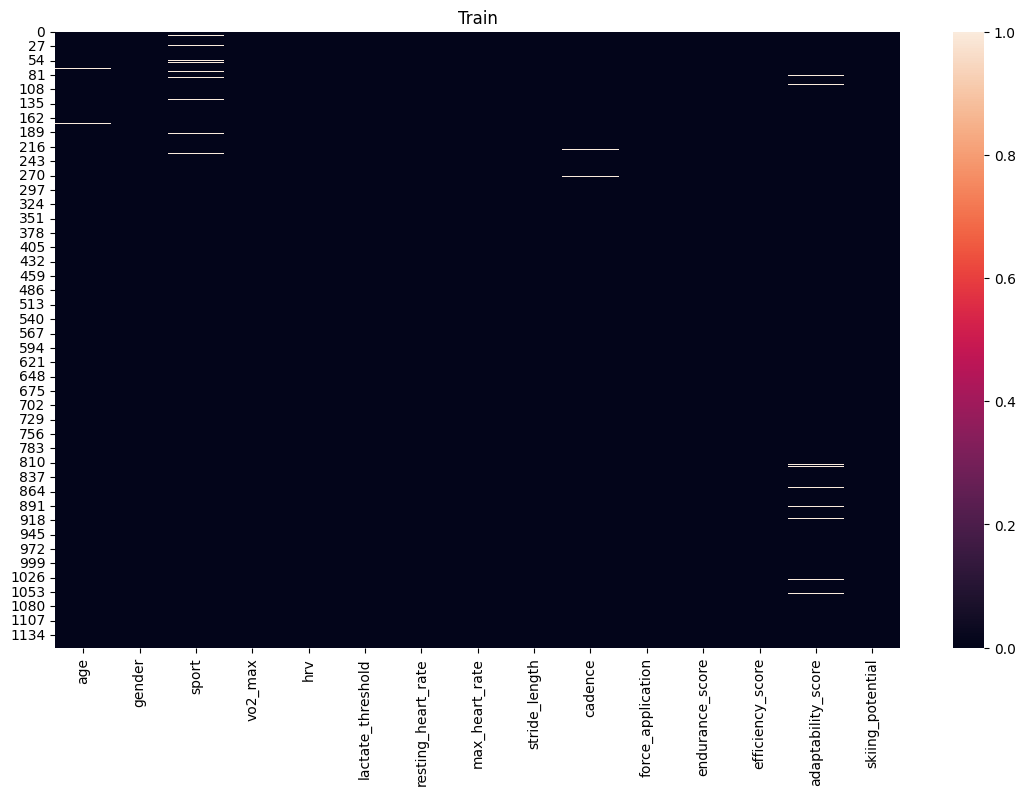

In [36]:
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.heatmap(df[df.columns[1:]].isnull())
ax.title.set_text('Train')
plt.show()

In [37]:
# разделю athlete_id на две части, получив RUN и номер
df[["t_athlete", 'n_athlete']] = df["athlete_id"].str.split('_', expand=True)
df = df.astype({'t_athlete': 'str', 'n_athlete': 'int'})
#Set the Index
df.set_index('athlete_id',inplace=True)

df.head()

,age,gender,sport,vo2_max,hrv,lactate_threshold,resting_heart_rate,max_heart_rate,stride_length,cadence,force_application,endurance_score,efficiency_score,adaptability_score,skiing_potential,t_athlete,n_athlete
athlete_id,,,,,,,,,,,,,,,,,
RUN_1,23.0,Female,Running,62.21,116.50,75.97,45,179,1.08,89.0,466.50,91.94,75.17,91.67,0.54,RUN,1
RUN_2,20.0,Male,Running,50.98,98.90,78.68,41,198,0.80,65.0,528.12,65.22,64.80,80.85,0.13,RUN,2
RUN_3,22.0,Female,Running,68.55,56.96,72.11,49,179,0.92,97.0,304.43,50.73,61.85,93.61,0.93,RUN,3
RUN_4,26.0,Female,Running,57.89,56.20,83.94,56,192,0.89,60.0,520.07,77.56,94.52,70.17,0.15,RUN,4
RUN_5,22.0,Male,NaN,56.31,101.21,80.60,58,176,1.47,66.0,340.50,74.46,52.44,52.87,0.03,RUN,5


In [38]:
# соберем в отдельный список все категориальные признаки
categorical_features = df.select_dtypes(include = ['object']).columns.to_list()

# соберем в отдельный список все числовые признаки
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

print("Категориальные признаки:")
print(categorical_features)
print("--------------------------")
print("Числовые признаки:")
print(numeric_features)

Категориальные признаки:
['gender', 'sport', 't_athlete']
--------------------------
Числовые признаки:
['age', 'vo2_max', 'hrv', 'lactate_threshold', 'resting_heart_rate', 'max_heart_rate', 'stride_length', 'cadence', 'force_application', 'endurance_score', 'efficiency_score', 'adaptability_score', 'skiing_potential', 'n_athlete']


In [39]:
# заполняю null в категориальном признаке 'sport' значение 'Running'
df['sport'] = df['sport'].fillna('Running')

In [40]:
# заполняю пропуски в числовых признаках средним значением
for col in ['age', 'cadence', 'adaptability_score']:
    df[col] = df[col].fillna(df[col].mean()).astype(float)

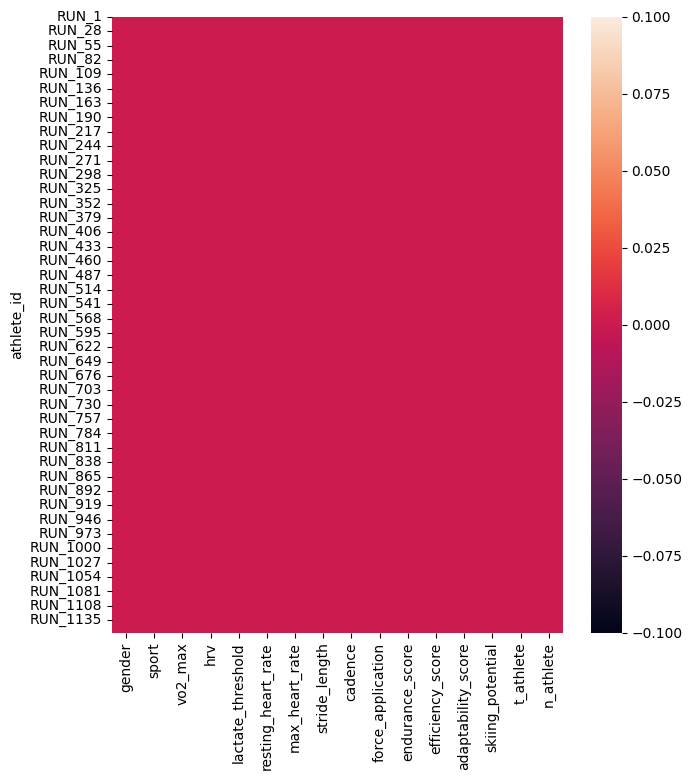

In [41]:
# итоговая проверка. Видим, что пропущенные значения отсутствуют
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.heatmap(df[df.columns[1:]].isnull())

plt.show()

In [42]:
scaler = StandardScaler()
ohe=OneHotEncoder(sparse_output=False)
data_scaled = scaler.fit_transform(df[numeric_features])
data_ohe = ohe.fit_transform(df[categorical_features])

In [43]:
print(data_scaled)
print(data_ohe)

[[-0.63266198 -0.03464864  1.58106013 ...  1.114374    0.13312073
  -1.73055573]
 [-1.2575557  -1.12970471  0.69214601 ...  0.36712583 -1.28430607
  -1.72756427]
 [-0.84095989  0.58357535 -1.42609595 ...  1.2483538   1.48140476
  -1.72457282]
 ...
 [ 1.24201917 -1.44369229 -1.47003659 ... -0.13495311 -1.31887746
   1.72457282]
 [-1.0492578   0.15354888 -1.36094258 ... -1.01134675 -0.86944945
   1.72756427]
 [-1.46585361  0.92584132 -1.59428254 ... -1.61356524  1.27397645
   1.73055573]]
[[1. 0. 1. 1.]
 [0. 1. 1. 1.]
 [1. 0. 1. 1.]
 ...
 [0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 1. 1. 1.]]


In [46]:
# Выбираю только числовые признаки
numeric_df = df.select_dtypes(include=[np.number])

# Вычисляю матрицу корреляции
correlation_matrix = numeric_df.corr()

print("Матрица корреляции:")
print(correlation_matrix)

Матрица корреляции:
                         age   vo2_max       hrv  lactate_threshold  \
age                 1.000000  0.016397  0.017957           0.018024   
vo2_max             0.016397  1.000000 -0.010722           0.004520   
hrv                 0.017957 -0.010722  1.000000           0.040363   
lactate_threshold   0.018024  0.004520  0.040363           1.000000   
resting_heart_rate  0.029465 -0.049014 -0.025536          -0.019692   
max_heart_rate     -0.022441 -0.051719 -0.001713          -0.021075   
stride_length       0.022477 -0.009478 -0.000805          -0.062956   
cadence            -0.010098 -0.016209  0.022536           0.024447   
force_application  -0.042548 -0.027446 -0.039133           0.033903   
endurance_score    -0.039804 -0.005570 -0.000589           0.000341   
efficiency_score   -0.006489 -0.043677 -0.014536          -0.033393   
adaptability_score  0.072308  0.021473 -0.035187           0.011786   
skiing_potential   -0.034004 -0.003044 -0.018366         

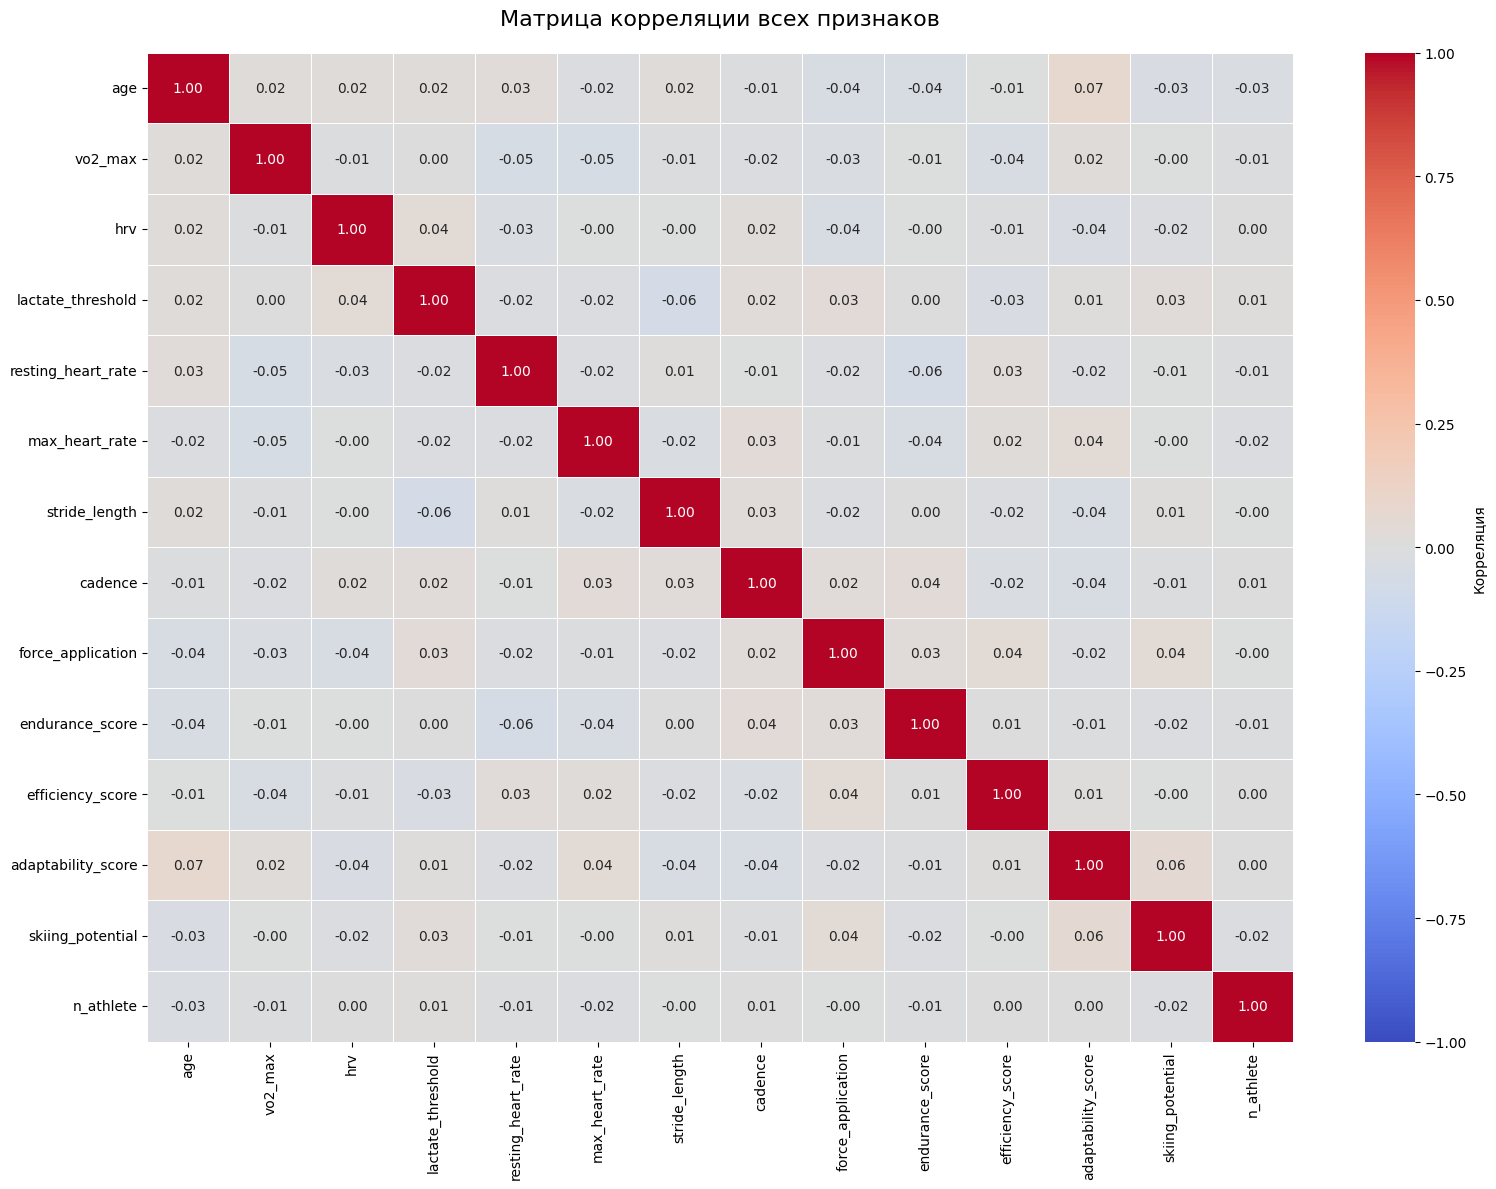

In [47]:
# Создаю большую тепловую карту для всех признаков
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Корреляция'})
plt.title('Матрица корреляции всех признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Важность признаков:
               Feature  Importance
4     efficiency_score    0.920913
10  adaptability_score    0.012291
3    lactate_threshold    0.010666
0              vo2_max    0.009235
9    force_application    0.008562
7        stride_length    0.008290
5      endurance_score    0.007540
1                  hrv    0.007068
6       max_heart_rate    0.005832
8              cadence    0.005240
2   resting_heart_rate    0.004362


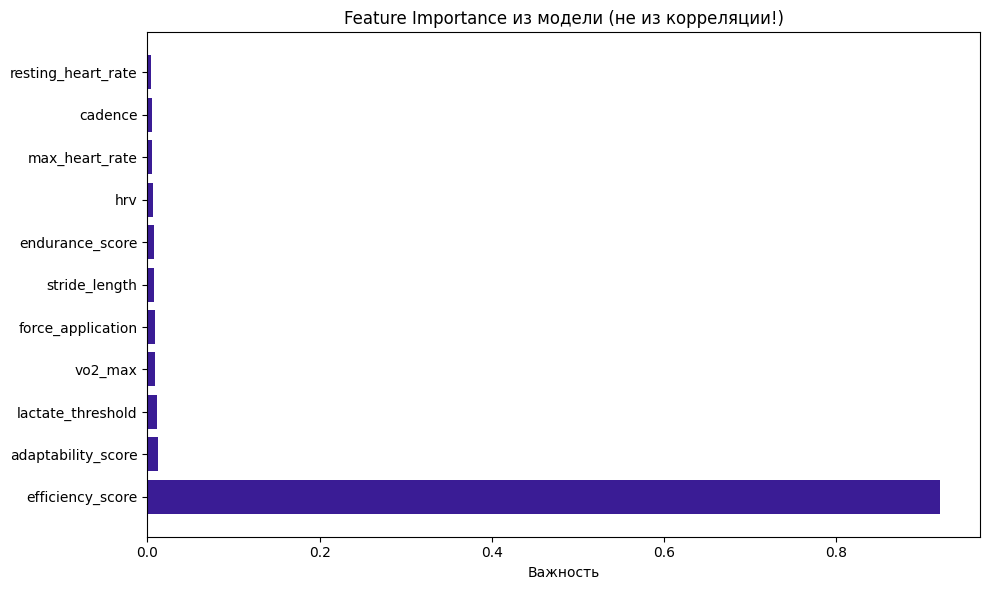

In [206]:
# Подготовливаю целевую переменную
key_features = ['vo2_max', 'hrv', 'resting_heart_rate', 'lactate_threshold', 'efficiency_score', 
                'endurance_score', 'max_heart_rate', 'stride_length', 'cadence', 'force_application',
                'adaptability_score']

df_clean = df.dropna(subset=key_features)
df_clean['target'] = (df_clean['efficiency_score'] > df_clean['efficiency_score'].quantile(0.5)).astype(int)

# Нормализую
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[key_features])

# Обучить модель со ВСЕМИ признаками
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, df_clean['target'])

# Посмотрите важность
feature_importance = pd.DataFrame({
    'Feature': key_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Важность признаков:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color="#3A1C95")
plt.xlabel('Важность')
plt.title('Feature Importance из модели (не из корреляции!)')
plt.tight_layout()
plt.show()


In [49]:
key_features = ['vo2_max', 'hrv', 'lactate_threshold', 'efficiency_score', 
                'endurance_score', 'adaptability_score']

#НОРМАЛИЗАЦИЯ
scaler = StandardScaler()
df = pd.DataFrame(
    scaler.fit_transform(df[key_features]),
    columns=key_features
)

#КОНСТРУИРОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (на обработанных данных!)
weights = {
    'vo2_max': 0.10,
    'lactate_threshold': 0.15,
    'efficiency_score': 0.40,
    'endurance_score': 0.15,
    'adaptability_score': 0.15,
    'hrv': 0.05
}

df['success_index'] = 0
for i, feature in enumerate(key_features):
    df['success_index'] += df.iloc[:, i] * list(weights.values())[i]

#ЦЕЛЕВАЯ ПЕРЕМЕННАЯ
df['successful_completion'] = (
    df['success_index'] > df['success_index'].median()
).astype(int)

print("Распределение классов целевой переменной:")
print(df['successful_completion'].value_counts())
print(f"\nКорректность: {df['successful_completion'].isna().sum()} пропусков")

Распределение классов целевой переменной:
successful_completion
1    579
0    579
Name: count, dtype: int64

Корректность: 0 пропусков


In [50]:
# Очистка данные
df_clean = df.dropna(subset=key_features + ['successful_completion'])

X = df_clean[key_features]
y = df_clean['successful_completion']

# Разделяю данные ан train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"Тренировочный набор: {X_train.shape}")
print(f"Тестовый набор: {X_test.shape}")
print(f"\nРаспределение в тренировочном наборе:\n{y_train.value_counts()}")

Тренировочный набор: (926, 6)
Тестовый набор: (232, 6)

Распределение в тренировочном наборе:
successful_completion
1    463
0    463
Name: count, dtype: int64


# Стекинг (Stacking) с Optuna

In [51]:
def objective_stacking(trial):
    """
    Функция цели для оптимизации стекинга
    """
    
    # 1. Гиперпараметры для базовых моделей
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
    
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 50, 200)
    gb_learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.3)
    
    svc_c = trial.suggest_float('svc_c', 0.1, 100, log=True)
    
    # 2. Гиперпараметры для логистической регрессии (мета-модель)
    lr_c = trial.suggest_float('lr_c', 0.1, 100, log=True)
    
    # 3. Базовые модели
    base_learners = [
        ('rf', RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            random_state=42,
            n_jobs=-1
        )),
        ('gb', GradientBoostingClassifier(
            n_estimators=gb_n_estimators,
            learning_rate=gb_learning_rate,
            random_state=42
        )),
        ('svc', SVC(C=svc_c, kernel='rbf', probability=True, random_state=42))
    ]
    
    # 4. Мета-модель (финальный классификатор)
    meta_model = LogisticRegression(C=lr_c, max_iter=1000, random_state=42)
    
    # 5. Создаю стекинг классификатор
    stacking_model = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_model,
        cv=5  # 5-fold кросс-валидация для генерации метапризнаков
    )
    
    # 6. Кросс-валидация
    scores = cross_val_score(
        stacking_model, X_train_scaled, y_train,
        cv=5, scoring='accuracy'
    )
    
    return scores.mean()

# Запускаю оптимизацию для стекинга
print("Оптимизация СТЕКИНГА...")
study_stacking = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study_stacking.optimize(objective_stacking, n_trials=30, show_progress_bar=True)

print(f"\nЛучшие гиперпараметры (Стекинг): {study_stacking.best_params}")
print(f"Лучшая точность: {study_stacking.best_value:.4f}")

[I 2025-12-06 17:39:12,578] A new study created in memory with name: no-name-237fb991-cfc3-4d91-9956-fb831885f1ea


Оптимизация СТЕКИНГА...


Best trial: 0. Best value: 0.953577:   3%|▎         | 1/30 [00:13<06:39, 13.77s/it]

[I 2025-12-06 17:39:26,353] Trial 0 finished with value: 0.9535774484161582 and parameters: {'rf_n_estimators': 106, 'rf_max_depth': 20, 'gb_n_estimators': 160, 'gb_learning_rate': 0.18361096041714062, 'svc_c': 0.2938027938703535, 'lr_c': 0.2937538457632829}. Best is trial 0 with value: 0.9535774484161582.


Best trial: 1. Best value: 0.957884:   7%|▋         | 2/30 [00:27<06:16, 13.45s/it]

[I 2025-12-06 17:39:39,588] Trial 1 finished with value: 0.957884335948852 and parameters: {'rf_n_estimators': 58, 'rf_max_depth': 18, 'gb_n_estimators': 140, 'gb_learning_rate': 0.21534104756085318, 'svc_c': 0.115279871282324, 'lr_c': 81.23245085588688}. Best is trial 1 with value: 0.957884335948852.


Best trial: 2. Best value: 0.958977:  10%|█         | 3/30 [00:43<06:45, 15.03s/it]

[I 2025-12-06 17:39:56,484] Trial 2 finished with value: 0.9589770415576867 and parameters: {'rf_n_estimators': 175, 'rf_max_depth': 8, 'gb_n_estimators': 77, 'gb_learning_rate': 0.06318730785749581, 'svc_c': 0.8179499475211672, 'lr_c': 3.752055855124281}. Best is trial 2 with value: 0.9589770415576867.


Best trial: 3. Best value: 0.960058:  13%|█▎        | 4/30 [01:02<07:10, 16.55s/it]

[I 2025-12-06 17:40:15,368] Trial 3 finished with value: 0.9600581226387679 and parameters: {'rf_n_estimators': 115, 'rf_max_depth': 9, 'gb_n_estimators': 142, 'gb_learning_rate': 0.05045321958909213, 'svc_c': 0.7523742884534856, 'lr_c': 1.2562773503807025}. Best is trial 3 with value: 0.9600581226387679.


Best trial: 3. Best value: 0.960058:  17%|█▋        | 5/30 [01:15<06:18, 15.14s/it]

[I 2025-12-06 17:40:28,015] Trial 4 finished with value: 0.9557396105783204 and parameters: {'rf_n_estimators': 118, 'rf_max_depth': 17, 'gb_n_estimators': 80, 'gb_learning_rate': 0.15912798713994736, 'svc_c': 5.9874749104613985, 'lr_c': 0.13783237455007183}. Best is trial 3 with value: 0.9600581226387679.


Best trial: 3. Best value: 0.960058:  20%|██        | 6/30 [01:27<05:37, 14.08s/it]

[I 2025-12-06 17:40:40,036] Trial 5 finished with value: 0.9525021795989538 and parameters: {'rf_n_estimators': 141, 'rf_max_depth': 7, 'gb_n_estimators': 59, 'gb_learning_rate': 0.2851768058034666, 'svc_c': 78.86714129990483, 'lr_c': 26.619018884890558}. Best is trial 3 with value: 0.9600581226387679.


Best trial: 6. Best value: 0.961133:  23%|██▎       | 7/30 [01:44<05:43, 14.92s/it]

[I 2025-12-06 17:40:56,681] Trial 6 finished with value: 0.9611333914559722 and parameters: {'rf_n_estimators': 95, 'rf_max_depth': 6, 'gb_n_estimators': 153, 'gb_learning_rate': 0.13764422318448438, 'svc_c': 0.2323350351539011, 'lr_c': 3.0586566669785253}. Best is trial 6 with value: 0.9611333914559722.


Best trial: 7. Best value: 0.962226:  27%|██▋       | 8/30 [01:53<04:50, 13.20s/it]

[I 2025-12-06 17:41:06,198] Trial 7 finished with value: 0.9622260970648068 and parameters: {'rf_n_estimators': 55, 'rf_max_depth': 19, 'gb_n_estimators': 89, 'gb_learning_rate': 0.20213146246265476, 'svc_c': 0.8612579192594884, 'lr_c': 3.632486956676605}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  30%|███       | 9/30 [02:12<05:16, 15.06s/it]

[I 2025-12-06 17:41:25,362] Trial 8 finished with value: 0.9525021795989538 and parameters: {'rf_n_estimators': 132, 'rf_max_depth': 7, 'gb_n_estimators': 196, 'gb_learning_rate': 0.2347885187747232, 'svc_c': 65.84106160121607, 'lr_c': 48.35952776465949}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  33%|███▎      | 10/30 [02:25<04:45, 14.30s/it]

[I 2025-12-06 17:41:37,947] Trial 9 finished with value: 0.9568148793955246 and parameters: {'rf_n_estimators': 140, 'rf_max_depth': 19, 'gb_n_estimators': 63, 'gb_learning_rate': 0.0668350301015521, 'svc_c': 0.13667272915456222, 'lr_c': 0.946217535646149}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  37%|███▋      | 11/30 [02:36<04:12, 13.31s/it]

[I 2025-12-06 17:41:49,029] Trial 10 finished with value: 0.9546643417611159 and parameters: {'rf_n_estimators': 53, 'rf_max_depth': 14, 'gb_n_estimators': 105, 'gb_learning_rate': 0.11058675850792035, 'svc_c': 6.7986249190301065, 'lr_c': 11.769044926591633}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  40%|████      | 12/30 [02:48<03:53, 12.98s/it]

[I 2025-12-06 17:42:01,249] Trial 11 finished with value: 0.9557454228421971 and parameters: {'rf_n_estimators': 82, 'rf_max_depth': 12, 'gb_n_estimators': 111, 'gb_learning_rate': 0.12008523059186482, 'svc_c': 1.566602238376503, 'lr_c': 5.180143688462551}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  43%|████▎     | 13/30 [03:04<03:53, 13.71s/it]

[I 2025-12-06 17:42:16,643] Trial 12 finished with value: 0.9600639349026446 and parameters: {'rf_n_estimators': 79, 'rf_max_depth': 5, 'gb_n_estimators': 171, 'gb_learning_rate': 0.12434735576258887, 'svc_c': 0.39820011262840554, 'lr_c': 0.852454851774625}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  47%|████▋     | 14/30 [03:15<03:30, 13.16s/it]

[I 2025-12-06 17:42:28,526] Trial 13 finished with value: 0.9568323161871548 and parameters: {'rf_n_estimators': 85, 'rf_max_depth': 14, 'gb_n_estimators': 104, 'gb_learning_rate': 0.24472576250867625, 'svc_c': 2.627692014927503, 'lr_c': 9.38660857849054}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  50%|█████     | 15/30 [03:29<03:17, 13.14s/it]

[I 2025-12-06 17:42:41,630] Trial 14 finished with value: 0.9568148793955246 and parameters: {'rf_n_estimators': 67, 'rf_max_depth': 11, 'gb_n_estimators': 128, 'gb_learning_rate': 0.18179150514254255, 'svc_c': 0.3262959590866131, 'lr_c': 2.342232862163071}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  53%|█████▎    | 16/30 [03:46<03:21, 14.37s/it]

[I 2025-12-06 17:42:58,861] Trial 15 finished with value: 0.9503342051729149 and parameters: {'rf_n_estimators': 100, 'rf_max_depth': 16, 'gb_n_estimators': 173, 'gb_learning_rate': 0.2894709024783464, 'svc_c': 24.773342515564075, 'lr_c': 12.539246081686093}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  57%|█████▋    | 17/30 [04:02<03:13, 14.90s/it]

[I 2025-12-06 17:43:14,975] Trial 16 finished with value: 0.961139203719849 and parameters: {'rf_n_estimators': 164, 'rf_max_depth': 5, 'gb_n_estimators': 120, 'gb_learning_rate': 0.20339613431352532, 'svc_c': 1.1153337035873074, 'lr_c': 2.1221972428553038}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  60%|██████    | 18/30 [04:22<03:16, 16.35s/it]

[I 2025-12-06 17:43:34,706] Trial 17 finished with value: 0.9579075850043592 and parameters: {'rf_n_estimators': 194, 'rf_max_depth': 10, 'gb_n_estimators': 89, 'gb_learning_rate': 0.20442123415082927, 'svc_c': 1.4306772605521858, 'lr_c': 0.5740275196446932}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  63%|██████▎   | 19/30 [04:39<03:02, 16.58s/it]

[I 2025-12-06 17:43:51,840] Trial 18 finished with value: 0.9557512351060738 and parameters: {'rf_n_estimators': 162, 'rf_max_depth': 15, 'gb_n_estimators': 120, 'gb_learning_rate': 0.2602489233374433, 'svc_c': 6.150458525255386, 'lr_c': 1.8214869190736251}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  67%|██████▋   | 20/30 [04:54<02:41, 16.13s/it]

[I 2025-12-06 17:44:06,924] Trial 19 finished with value: 0.9568206916594015 and parameters: {'rf_n_estimators': 161, 'rf_max_depth': 13, 'gb_n_estimators': 94, 'gb_learning_rate': 0.18568417714098318, 'svc_c': 14.601920314970474, 'lr_c': 0.35407805304457723}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  70%|███████   | 21/30 [05:10<02:24, 16.03s/it]

[I 2025-12-06 17:44:22,722] Trial 20 finished with value: 0.9622144725370532 and parameters: {'rf_n_estimators': 199, 'rf_max_depth': 20, 'gb_n_estimators': 51, 'gb_learning_rate': 0.09003042532138131, 'svc_c': 0.6293134359111122, 'lr_c': 7.516850513426518}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  73%|███████▎  | 22/30 [05:24<02:05, 15.65s/it]

[I 2025-12-06 17:44:37,486] Trial 21 finished with value: 0.9611333914559722 and parameters: {'rf_n_estimators': 194, 'rf_max_depth': 20, 'gb_n_estimators': 53, 'gb_learning_rate': 0.0907178289715576, 'svc_c': 0.6554852086213101, 'lr_c': 6.131070620245735}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  77%|███████▋  | 23/30 [05:42<01:52, 16.13s/it]

[I 2025-12-06 17:44:54,741] Trial 22 finished with value: 0.9568323161871548 and parameters: {'rf_n_estimators': 180, 'rf_max_depth': 18, 'gb_n_estimators': 75, 'gb_learning_rate': 0.022503608815514692, 'svc_c': 1.5959635848083016, 'lr_c': 25.18367648213806}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  80%|████████  | 24/30 [06:01<01:43, 17.25s/it]

[I 2025-12-06 17:45:14,584] Trial 23 finished with value: 0.95897122929381 and parameters: {'rf_n_estimators': 156, 'rf_max_depth': 17, 'gb_n_estimators': 70, 'gb_learning_rate': 0.1570935983487118, 'svc_c': 0.6724833767797653, 'lr_c': 5.914677945800731}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  83%|████████▎ | 25/30 [06:24<01:33, 18.71s/it]

[I 2025-12-06 17:45:36,683] Trial 24 finished with value: 0.9600697471665214 and parameters: {'rf_n_estimators': 200, 'rf_max_depth': 20, 'gb_n_estimators': 51, 'gb_learning_rate': 0.2157611972205985, 'svc_c': 2.2960514062786515, 'lr_c': 1.5629003615052806}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  87%|████████▋ | 26/30 [06:42<01:14, 18.67s/it]

[I 2025-12-06 17:45:55,282] Trial 25 finished with value: 0.9568323161871548 and parameters: {'rf_n_estimators': 177, 'rf_max_depth': 18, 'gb_n_estimators': 90, 'gb_learning_rate': 0.01196490867345458, 'svc_c': 1.0738385494671747, 'lr_c': 17.01110116239513}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 7. Best value: 0.962226:  90%|█████████ | 27/30 [06:59<00:54, 18.09s/it]

[I 2025-12-06 17:46:12,015] Trial 26 finished with value: 0.9557279860505667 and parameters: {'rf_n_estimators': 151, 'rf_max_depth': 16, 'gb_n_estimators': 125, 'gb_learning_rate': 0.09653023760284336, 'svc_c': 0.1901757460007574, 'lr_c': 3.5594361984208556}. Best is trial 7 with value: 0.9622260970648068.


Best trial: 27. Best value: 0.963296:  93%|█████████▎| 28/30 [07:19<00:37, 18.77s/it]

[I 2025-12-06 17:46:32,360] Trial 27 finished with value: 0.9632955536181343 and parameters: {'rf_n_estimators': 181, 'rf_max_depth': 19, 'gb_n_estimators': 115, 'gb_learning_rate': 0.1432123272159842, 'svc_c': 0.46489251927836356, 'lr_c': 8.12187939272183}. Best is trial 27 with value: 0.9632955536181343.


Best trial: 28. Best value: 0.965452:  97%|█████████▋| 29/30 [07:38<00:18, 18.90s/it]

[I 2025-12-06 17:46:51,562] Trial 28 finished with value: 0.9654519035164195 and parameters: {'rf_n_estimators': 184, 'rf_max_depth': 19, 'gb_n_estimators': 98, 'gb_learning_rate': 0.14148052865293004, 'svc_c': 0.41694915817538103, 'lr_c': 8.299545915215292}. Best is trial 28 with value: 0.9654519035164195.


Best trial: 29. Best value: 0.966533: 100%|██████████| 30/30 [07:55<00:00, 15.84s/it]

[I 2025-12-06 17:47:07,798] Trial 29 finished with value: 0.9665329845975007 and parameters: {'rf_n_estimators': 180, 'rf_max_depth': 18, 'gb_n_estimators': 98, 'gb_learning_rate': 0.17527258793262468, 'svc_c': 0.41201517120486236, 'lr_c': 20.812479192277646}. Best is trial 29 with value: 0.9665329845975007.

Лучшие гиперпараметры (Стекинг): {'rf_n_estimators': 180, 'rf_max_depth': 18, 'gb_n_estimators': 98, 'gb_learning_rate': 0.17527258793262468, 'svc_c': 0.41201517120486236, 'lr_c': 20.812479192277646}
Лучшая точность: 0.9665


# Ансамбль с Бустингом и Логистической Регрессией

In [52]:
def objective_boosting_ensemble(trial):
    """
    Функция цели для оптимизации ансамбля с бустингом
    """
    
    # Гиперпараметры для GradientBoosting
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 50, 200)
    gb_learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.3)
    gb_max_depth = trial.suggest_int('gb_max_depth', 3, 10)
    
    # Гиперпараметры для RandomForest
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    
    # Базовые модели с бустингом
    base_learners = [
        ('gb', GradientBoostingClassifier(
            n_estimators=gb_n_estimators,
            learning_rate=gb_learning_rate,
            max_depth=gb_max_depth,
            random_state=42
        )),
        ('rf', RandomForestClassifier(
            n_estimators=rf_n_estimators,
            random_state=42,
            n_jobs=-1
        ))
    ]
    
    # VotingClassifier (голосование) или StackingClassifier
    voting_model = VotingClassifier(
        estimators=base_learners,
        voting='soft'  # 'soft' для вероятностных предсказаний
    )
    
    # Кросс-валидация
    scores = cross_val_score(
        voting_model, X_train_scaled, y_train,
        cv=5, scoring='accuracy'
    ) 
    return scores.mean()

# Запускаю оптимизацию для бустинга
print("Оптимизация БУСТИНГА...")
study_boosting = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study_boosting.optimize(objective_boosting_ensemble, n_trials=30, show_progress_bar=True)

print(f"\nЛучшие гиперпараметры (Бустинг): {study_boosting.best_params}")
print(f"Лучшая точность: {study_boosting.best_value:.4f}")

[I 2025-12-06 17:47:43,388] A new study created in memory with name: no-name-cbbd2110-483a-4be9-bd0a-78380b391767


Оптимизация БУСТИНГА...


Best trial: 0. Best value: 0.877983:   3%|▎         | 1/30 [00:03<01:31,  3.16s/it]

[I 2025-12-06 17:47:46,547] Trial 0 finished with value: 0.8779831444347573 and parameters: {'gb_n_estimators': 106, 'gb_learning_rate': 0.28570714885887566, 'gb_max_depth': 8, 'rf_n_estimators': 140}. Best is trial 0 with value: 0.8779831444347573.


Best trial: 1. Best value: 0.917931:   7%|▋         | 2/30 [00:05<01:10,  2.52s/it]

[I 2025-12-06 17:47:48,613] Trial 1 finished with value: 0.9179308340598663 and parameters: {'gb_n_estimators': 73, 'gb_learning_rate': 0.055238410897498764, 'gb_max_depth': 3, 'rf_n_estimators': 180}. Best is trial 1 with value: 0.9179308340598663.


Best trial: 2. Best value: 0.931973:  10%|█         | 3/30 [00:07<01:09,  2.58s/it]

[I 2025-12-06 17:47:51,278] Trial 2 finished with value: 0.9319732635861667 and parameters: {'gb_n_estimators': 140, 'gb_learning_rate': 0.21534104756085318, 'gb_max_depth': 3, 'rf_n_estimators': 196}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  13%|█▎        | 4/30 [00:10<01:10,  2.71s/it]

[I 2025-12-06 17:47:54,179] Trial 3 finished with value: 0.9233362394652718 and parameters: {'gb_n_estimators': 175, 'gb_learning_rate': 0.07157834209670008, 'gb_max_depth': 4, 'rf_n_estimators': 77}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  17%|█▋        | 5/30 [00:13<01:07,  2.71s/it]

[I 2025-12-06 17:47:56,886] Trial 4 finished with value: 0.9179250217959897 and parameters: {'gb_n_estimators': 95, 'gb_learning_rate': 0.16217936517334897, 'gb_max_depth': 6, 'rf_n_estimators': 93}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  20%|██        | 6/30 [00:18<01:26,  3.61s/it]

[I 2025-12-06 17:48:02,242] Trial 5 finished with value: 0.9211682650392328 and parameters: {'gb_n_estimators': 142, 'gb_learning_rate': 0.05045321958909213, 'gb_max_depth': 5, 'rf_n_estimators': 105}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  23%|██▎       | 7/30 [00:21<01:19,  3.44s/it]

[I 2025-12-06 17:48:05,325] Trial 6 finished with value: 0.9244231328102297 and parameters: {'gb_n_estimators': 118, 'gb_learning_rate': 0.23770102880397392, 'gb_max_depth': 4, 'rf_n_estimators': 127}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  27%|██▋       | 8/30 [00:27<01:28,  4.01s/it]

[I 2025-12-06 17:48:10,575] Trial 7 finished with value: 0.9039116535890731 and parameters: {'gb_n_estimators': 139, 'gb_learning_rate': 0.02347061968879934, 'gb_max_depth': 7, 'rf_n_estimators': 75}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  30%|███       | 9/30 [00:30<01:17,  3.69s/it]

[I 2025-12-06 17:48:13,542] Trial 8 finished with value: 0.870409764603313 and parameters: {'gb_n_estimators': 59, 'gb_learning_rate': 0.2851768058034666, 'gb_max_depth': 10, 'rf_n_estimators': 172}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  33%|███▎      | 10/30 [00:33<01:12,  3.62s/it]

[I 2025-12-06 17:48:17,010] Trial 9 finished with value: 0.8758093577448417 and parameters: {'gb_n_estimators': 95, 'gb_learning_rate': 0.03832491306185132, 'gb_max_depth': 8, 'rf_n_estimators': 116}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 2. Best value: 0.931973:  37%|███▋      | 11/30 [00:37<01:10,  3.71s/it]

[I 2025-12-06 17:48:20,928] Trial 10 finished with value: 0.9298052891601278 and parameters: {'gb_n_estimators': 194, 'gb_learning_rate': 0.17206676049466552, 'gb_max_depth': 3, 'rf_n_estimators': 194}. Best is trial 2 with value: 0.9319732635861667.


Best trial: 11. Best value: 0.933049:  40%|████      | 12/30 [00:41<01:08,  3.81s/it]

[I 2025-12-06 17:48:24,958] Trial 11 finished with value: 0.9330485324033712 and parameters: {'gb_n_estimators': 195, 'gb_learning_rate': 0.1770478706017131, 'gb_max_depth': 3, 'rf_n_estimators': 198}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  43%|████▎     | 13/30 [00:44<01:02,  3.66s/it]

[I 2025-12-06 17:48:28,274] Trial 12 finished with value: 0.9330485324033712 and parameters: {'gb_n_estimators': 164, 'gb_learning_rate': 0.21779022520592756, 'gb_max_depth': 3, 'rf_n_estimators': 155}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  47%|████▋     | 14/30 [00:49<01:03,  3.94s/it]

[I 2025-12-06 17:48:32,876] Trial 13 finished with value: 0.9211682650392328 and parameters: {'gb_n_estimators': 172, 'gb_learning_rate': 0.11254350273565202, 'gb_max_depth': 5, 'rf_n_estimators': 151}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  50%|█████     | 15/30 [00:54<01:03,  4.24s/it]

[I 2025-12-06 17:48:37,790] Trial 14 finished with value: 0.9276547515257192 and parameters: {'gb_n_estimators': 199, 'gb_learning_rate': 0.21015076632300259, 'gb_max_depth': 5, 'rf_n_estimators': 163}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  53%|█████▎    | 16/30 [00:58<00:58,  4.16s/it]

[I 2025-12-06 17:48:41,773] Trial 15 finished with value: 0.9255100261551874 and parameters: {'gb_n_estimators': 169, 'gb_learning_rate': 0.12296377550882728, 'gb_max_depth': 4, 'rf_n_estimators': 151}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  57%|█████▋    | 17/30 [01:04<01:00,  4.63s/it]

[I 2025-12-06 17:48:47,507] Trial 16 finished with value: 0.91794245858762 and parameters: {'gb_n_estimators': 159, 'gb_learning_rate': 0.24535357908652228, 'gb_max_depth': 6, 'rf_n_estimators': 200}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  60%|██████    | 18/30 [01:08<00:55,  4.61s/it]

[I 2025-12-06 17:48:52,075] Trial 17 finished with value: 0.8747282766637607 and parameters: {'gb_n_estimators': 187, 'gb_learning_rate': 0.19853342637294208, 'gb_max_depth': 10, 'rf_n_estimators': 180}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  63%|██████▎   | 19/30 [01:12<00:49,  4.52s/it]

[I 2025-12-06 17:48:56,361] Trial 18 finished with value: 0.930886370241209 and parameters: {'gb_n_estimators': 151, 'gb_learning_rate': 0.11612810898190987, 'gb_max_depth': 3, 'rf_n_estimators': 136}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  67%|██████▋   | 20/30 [01:18<00:48,  4.82s/it]

[I 2025-12-06 17:49:01,877] Trial 19 finished with value: 0.9309038070328393 and parameters: {'gb_n_estimators': 183, 'gb_learning_rate': 0.2490260715579776, 'gb_max_depth': 4, 'rf_n_estimators': 57}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  70%|███████   | 21/30 [01:27<00:53,  5.92s/it]

[I 2025-12-06 17:49:10,390] Trial 20 finished with value: 0.9038767800058123 and parameters: {'gb_n_estimators': 163, 'gb_learning_rate': 0.17178930314575408, 'gb_max_depth': 7, 'rf_n_estimators': 156}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  73%|███████▎  | 22/30 [01:31<00:44,  5.57s/it]

[I 2025-12-06 17:49:15,124] Trial 21 finished with value: 0.930886370241209 and parameters: {'gb_n_estimators': 128, 'gb_learning_rate': 0.20470214288770963, 'gb_max_depth': 3, 'rf_n_estimators': 196}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  77%|███████▋  | 23/30 [01:36<00:37,  5.39s/it]

[I 2025-12-06 17:49:20,090] Trial 22 finished with value: 0.9308979947689625 and parameters: {'gb_n_estimators': 150, 'gb_learning_rate': 0.2317934890985954, 'gb_max_depth': 3, 'rf_n_estimators': 183}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  80%|████████  | 24/30 [01:41<00:31,  5.31s/it]

[I 2025-12-06 17:49:25,238] Trial 23 finished with value: 0.9211682650392328 and parameters: {'gb_n_estimators': 128, 'gb_learning_rate': 0.13595599100887437, 'gb_max_depth': 4, 'rf_n_estimators': 167}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  83%|████████▎ | 25/30 [01:49<00:30,  6.01s/it]

[I 2025-12-06 17:49:32,854] Trial 24 finished with value: 0.9254984016274339 and parameters: {'gb_n_estimators': 179, 'gb_learning_rate': 0.19153939819967575, 'gb_max_depth': 5, 'rf_n_estimators': 186}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  87%|████████▋ | 26/30 [01:55<00:23,  5.98s/it]

[I 2025-12-06 17:49:38,770] Trial 25 finished with value: 0.9276547515257192 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.26544269662817693, 'gb_max_depth': 3, 'rf_n_estimators': 168}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 11. Best value: 0.933049:  90%|█████████ | 27/30 [02:01<00:17,  5.98s/it]

[I 2025-12-06 17:49:44,770] Trial 26 finished with value: 0.9276547515257192 and parameters: {'gb_n_estimators': 156, 'gb_learning_rate': 0.14256085141844077, 'gb_max_depth': 4, 'rf_n_estimators': 141}. Best is trial 11 with value: 0.9330485324033712.


Best trial: 27. Best value: 0.933066:  93%|█████████▎| 28/30 [02:05<00:11,  5.53s/it]

[I 2025-12-06 17:49:49,237] Trial 27 finished with value: 0.9330659691950014 and parameters: {'gb_n_estimators': 140, 'gb_learning_rate': 0.22074319216630545, 'gb_max_depth': 3, 'rf_n_estimators': 189}. Best is trial 27 with value: 0.9330659691950014.


Best trial: 27. Best value: 0.933066:  97%|█████████▋| 29/30 [02:14<00:06,  6.49s/it]

[I 2025-12-06 17:49:57,954] Trial 28 finished with value: 0.8725661145015984 and parameters: {'gb_n_estimators': 185, 'gb_learning_rate': 0.09283456014388253, 'gb_max_depth': 9, 'rf_n_estimators': 177}. Best is trial 27 with value: 0.9330659691950014.


Best trial: 27. Best value: 0.933066: 100%|██████████| 30/30 [02:19<00:00,  4.64s/it]

[I 2025-12-06 17:50:02,669] Trial 29 finished with value: 0.9201046207497822 and parameters: {'gb_n_estimators': 105, 'gb_learning_rate': 0.2896737931949068, 'gb_max_depth': 5, 'rf_n_estimators': 140}. Best is trial 27 with value: 0.9330659691950014.

Лучшие гиперпараметры (Бустинг): {'gb_n_estimators': 140, 'gb_learning_rate': 0.22074319216630545, 'gb_max_depth': 3, 'rf_n_estimators': 189}
Лучшая точность: 0.9331


In [215]:
# ============ Функция цели для Optuna ============
def objective(trial):
    # Гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    # Нормализацяи
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Создаю модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Кросс-валидация
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    return scores.mean()

# ============ Создание и запуск исследования ============
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# ============ Результаты ============
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ OPTUNA")
print("="*50)
print(f"\nЛучшие гиперпараметры:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")
print(f"\nЛучшая точность (CV): {study.best_value:.4f}")


[I 2025-11-30 12:05:17,001] A new study created in memory with name: no-name-2087178c-f6bd-4a53-bb76-c8810943cd00
Best trial: 0. Best value: 0.92007:   2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

[I 2025-11-30 12:05:18,445] Trial 0 finished with value: 0.9200697471665213 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9200697471665213.


Best trial: 0. Best value: 0.92007:   4%|▍         | 2/50 [00:02<00:49,  1.03s/it]

[I 2025-11-30 12:05:19,228] Trial 1 finished with value: 0.9168206916594015 and parameters: {'n_estimators': 89, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9200697471665213.


Best trial: 0. Best value: 0.92007:   6%|▌         | 3/50 [00:03<01:03,  1.36s/it]

[I 2025-11-30 12:05:20,964] Trial 2 finished with value: 0.9157396105783203 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9200697471665213.


Best trial: 3. Best value: 0.925469:   8%|▊         | 4/50 [00:06<01:29,  1.95s/it]

[I 2025-11-30 12:05:23,828] Trial 3 finished with value: 0.9254693403080501 and parameters: {'n_estimators': 258, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9254693403080501.


Best trial: 3. Best value: 0.925469:  10%|█         | 5/50 [00:08<01:27,  1.95s/it]

[I 2025-11-30 12:05:25,766] Trial 4 finished with value: 0.9243940714908458 and parameters: {'n_estimators': 126, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9254693403080501.


Best trial: 5. Best value: 0.92655:  12%|█▏        | 6/50 [00:12<01:46,  2.41s/it] 

[I 2025-11-30 12:05:29,081] Trial 5 finished with value: 0.926550421389131 and parameters: {'n_estimators': 203, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  14%|█▍        | 7/50 [00:14<01:43,  2.40s/it]

[I 2025-11-30 12:05:31,464] Trial 6 finished with value: 0.9243824469630921 and parameters: {'n_estimators': 164, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  16%|█▌        | 8/50 [00:17<01:45,  2.52s/it]

[I 2025-11-30 12:05:34,226] Trial 7 finished with value: 0.9157512351060738 and parameters: {'n_estimators': 198, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  18%|█▊        | 9/50 [00:18<01:24,  2.06s/it]

[I 2025-11-30 12:05:35,291] Trial 8 finished with value: 0.9189828538215636 and parameters: {'n_estimators': 66, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  20%|██        | 10/50 [00:19<01:17,  1.94s/it]

[I 2025-11-30 12:05:36,961] Trial 9 finished with value: 0.9222319093286835 and parameters: {'n_estimators': 126, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  22%|██▏       | 11/50 [00:22<01:29,  2.29s/it]

[I 2025-11-30 12:05:40,044] Trial 10 finished with value: 0.9243998837547224 and parameters: {'n_estimators': 289, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.926550421389131.


Best trial: 5. Best value: 0.92655:  24%|██▍       | 12/50 [00:25<01:33,  2.46s/it]

[I 2025-11-30 12:05:42,877] Trial 11 finished with value: 0.9244056960185991 and parameters: {'n_estimators': 256, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 5 with value: 0.926550421389131.


Best trial: 12. Best value: 0.928713:  26%|██▌       | 13/50 [00:28<01:38,  2.66s/it]

[I 2025-11-30 12:05:45,993] Trial 12 finished with value: 0.9287125835512933 and parameters: {'n_estimators': 236, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9287125835512933.


Best trial: 13. Best value: 0.928724:  28%|██▊       | 14/50 [00:32<01:43,  2.88s/it]

[I 2025-11-30 12:05:49,396] Trial 13 finished with value: 0.9287242080790467 and parameters: {'n_estimators': 225, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  30%|███       | 15/50 [00:36<01:49,  3.13s/it]

[I 2025-11-30 12:05:53,094] Trial 14 finished with value: 0.9222260970648067 and parameters: {'n_estimators': 231, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  32%|███▏      | 16/50 [00:42<02:17,  4.04s/it]

[I 2025-11-30 12:05:59,234] Trial 15 finished with value: 0.9254751525719268 and parameters: {'n_estimators': 290, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  34%|███▍      | 17/50 [00:46<02:20,  4.26s/it]

[I 2025-11-30 12:06:04,028] Trial 16 finished with value: 0.9276256902063353 and parameters: {'n_estimators': 240, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  36%|███▌      | 18/50 [00:49<02:01,  3.81s/it]

[I 2025-11-30 12:06:06,794] Trial 17 finished with value: 0.9222260970648067 and parameters: {'n_estimators': 223, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  38%|███▊      | 19/50 [00:52<01:45,  3.39s/it]

[I 2025-11-30 12:06:09,195] Trial 18 finished with value: 0.9200639349026446 and parameters: {'n_estimators': 174, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  40%|████      | 20/50 [00:55<01:40,  3.35s/it]

[I 2025-11-30 12:06:12,459] Trial 19 finished with value: 0.9243940714908456 and parameters: {'n_estimators': 263, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  42%|████▏     | 21/50 [00:59<01:42,  3.52s/it]

[I 2025-11-30 12:06:16,375] Trial 20 finished with value: 0.9233188026736414 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  44%|████▍     | 22/50 [01:04<01:48,  3.87s/it]

[I 2025-11-30 12:06:21,046] Trial 21 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 231, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  46%|████▌     | 23/50 [01:07<01:40,  3.73s/it]

[I 2025-11-30 12:06:24,468] Trial 22 finished with value: 0.9254809648358036 and parameters: {'n_estimators': 243, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  48%|████▊     | 24/50 [01:10<01:30,  3.49s/it]

[I 2025-11-30 12:06:27,394] Trial 23 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 218, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  50%|█████     | 25/50 [01:13<01:25,  3.41s/it]

[I 2025-11-30 12:06:30,609] Trial 24 finished with value: 0.9276315024702122 and parameters: {'n_estimators': 266, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  52%|█████▏    | 26/50 [01:16<01:20,  3.37s/it]

[I 2025-11-30 12:06:33,895] Trial 25 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 274, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  54%|█████▍    | 27/50 [01:20<01:16,  3.34s/it]

[I 2025-11-30 12:06:37,147] Trial 26 finished with value: 0.926550421389131 and parameters: {'n_estimators': 271, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  56%|█████▌    | 28/50 [01:22<01:08,  3.09s/it]

[I 2025-11-30 12:06:39,679] Trial 27 finished with value: 0.9243882592269689 and parameters: {'n_estimators': 186, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  58%|█████▊    | 29/50 [01:25<01:04,  3.07s/it]

[I 2025-11-30 12:06:42,682] Trial 28 finished with value: 0.9243940714908456 and parameters: {'n_estimators': 248, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  60%|██████    | 30/50 [01:28<00:59,  2.98s/it]

[I 2025-11-30 12:06:45,476] Trial 29 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 211, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  62%|██████▏   | 31/50 [01:30<00:50,  2.64s/it]

[I 2025-11-30 12:06:47,310] Trial 30 finished with value: 0.9254693403080501 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  64%|██████▍   | 32/50 [01:33<00:48,  2.69s/it]

[I 2025-11-30 12:06:50,108] Trial 31 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 233, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  66%|██████▌   | 33/50 [01:36<00:48,  2.86s/it]

[I 2025-11-30 12:06:53,362] Trial 32 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 244, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  68%|██████▊   | 34/50 [01:39<00:49,  3.07s/it]

[I 2025-11-30 12:06:56,941] Trial 33 finished with value: 0.9233129904097647 and parameters: {'n_estimators': 277, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  70%|███████   | 35/50 [01:43<00:47,  3.18s/it]

[I 2025-11-30 12:07:00,375] Trial 34 finished with value: 0.9287067712874164 and parameters: {'n_estimators': 249, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  72%|███████▏  | 36/50 [01:45<00:41,  2.98s/it]

[I 2025-11-30 12:07:02,879] Trial 35 finished with value: 0.926550421389131 and parameters: {'n_estimators': 193, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  74%|███████▍  | 37/50 [01:49<00:40,  3.10s/it]

[I 2025-11-30 12:07:06,277] Trial 36 finished with value: 0.9157337983144436 and parameters: {'n_estimators': 258, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  76%|███████▌  | 38/50 [01:51<00:35,  2.94s/it]

[I 2025-11-30 12:07:08,848] Trial 37 finished with value: 0.922243533856437 and parameters: {'n_estimators': 215, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  78%|███████▊  | 39/50 [01:56<00:36,  3.36s/it]

[I 2025-11-30 12:07:13,171] Trial 38 finished with value: 0.9254693403080501 and parameters: {'n_estimators': 275, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  80%|████████  | 40/50 [02:00<00:37,  3.72s/it]

[I 2025-11-30 12:07:17,725] Trial 39 finished with value: 0.9254693403080501 and parameters: {'n_estimators': 254, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  82%|████████▏ | 41/50 [02:02<00:27,  3.11s/it]

[I 2025-11-30 12:07:19,414] Trial 40 finished with value: 0.9222319093286835 and parameters: {'n_estimators': 119, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  84%|████████▍ | 42/50 [02:05<00:24,  3.00s/it]

[I 2025-11-30 12:07:22,170] Trial 41 finished with value: 0.9265446091252543 and parameters: {'n_estimators': 238, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  86%|████████▌ | 43/50 [02:07<00:19,  2.75s/it]

[I 2025-11-30 12:07:24,337] Trial 42 finished with value: 0.9287125835512932 and parameters: {'n_estimators': 205, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  88%|████████▊ | 44/50 [02:09<00:15,  2.57s/it]

[I 2025-11-30 12:07:26,474] Trial 43 finished with value: 0.9287125835512932 and parameters: {'n_estimators': 206, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  90%|█████████ | 45/50 [02:11<00:12,  2.44s/it]

[I 2025-11-30 12:07:28,623] Trial 44 finished with value: 0.9254635280441732 and parameters: {'n_estimators': 181, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  92%|█████████▏| 46/50 [02:14<00:09,  2.46s/it]

[I 2025-11-30 12:07:31,138] Trial 45 finished with value: 0.926556233653008 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  94%|█████████▍| 47/50 [02:16<00:07,  2.50s/it]

[I 2025-11-30 12:07:33,738] Trial 46 finished with value: 0.9222260970648067 and parameters: {'n_estimators': 162, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  96%|█████████▌| 48/50 [02:19<00:05,  2.56s/it]

[I 2025-11-30 12:07:36,438] Trial 47 finished with value: 0.9287125835512932 and parameters: {'n_estimators': 205, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724:  98%|█████████▊| 49/50 [02:21<00:02,  2.50s/it]

[I 2025-11-30 12:07:38,804] Trial 48 finished with value: 0.9287125835512932 and parameters: {'n_estimators': 203, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9287242080790467.


Best trial: 13. Best value: 0.928724: 100%|██████████| 50/50 [02:24<00:00,  2.88s/it]

[I 2025-11-30 12:07:41,223] Trial 49 finished with value: 0.9254751525719268 and parameters: {'n_estimators': 224, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.9287242080790467.

РЕЗУЛЬТАТЫ OPTUNA

Лучшие гиперпараметры:
  n_estimators: 225
  max_depth: 16
  min_samples_split: 5
  min_samples_leaf: 2

Лучшая точность (CV): 0.9287


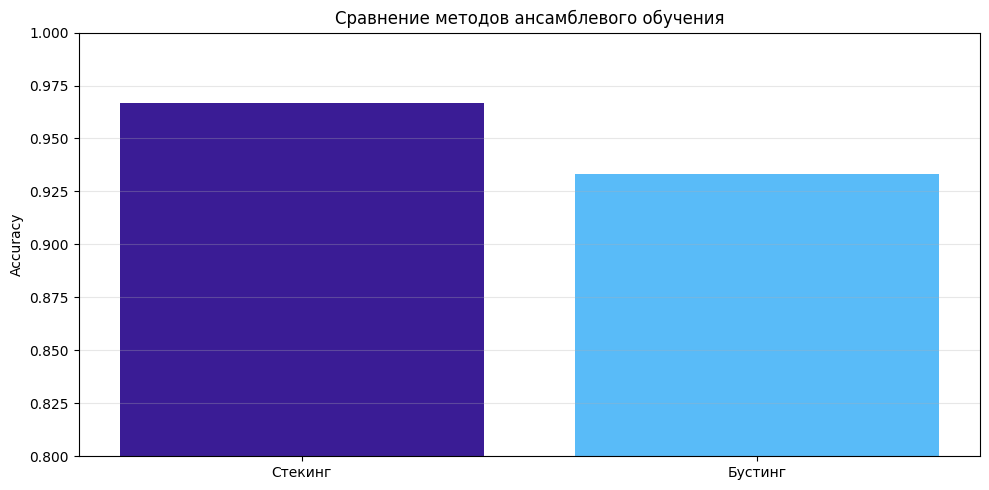


ИТОГОВОЕ СРАВНЕНИЕ
Стекинг         : 0.9665
Бустинг         : 0.9331


In [53]:
# Получаю лучшие значения из каждого исследования Optuna
results = {
    'Стекинг': study_stacking.best_value,      # accuracy из стекинга
    'Бустинг': study_boosting.best_value       # accuracy из бустинга
}

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=["#3A1C95", "#59BBF8"])
plt.ylabel('Accuracy')
plt.title('Сравнение методов ансамблевого обучения')
plt.ylim([0.8, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Вывод результатов
print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("="*60)

sorted_results = sorted(results.items(), key=operator.itemgetter(1), reverse=True)
for method, accuracy in sorted_results:
    print(f"{method:15} : {accuracy:.4f}")